In [8]:
# import necessary modules/libraries

import numpy as  np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [54]:
df = pd.read_csv('house_price_prediction.csv')
df['price'] = (df['price'] / 1000).round()
df = df[(df['price'] > 0) & (df['price'] < 10_000)].copy()
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year  # all 2014 so can drop
df['month'] = df['date'].dt.month  # only a few months
df['zip'] = df['statezip'].str.strip().str.lstrip('WA').str.strip().astype(int)
df['street_name'] = df['street'].str.strip().str.lstrip('-0123456789').str.strip().str.lower()
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,year,month,zip,street_name
0,2014-05-02,313.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA,2014,5,98133,densmore ave n
1,2014-05-02,2384.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA,2014,5,98119,w blaine st
2,2014-05-02,342.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA,2014,5,98042,143rd ave se
3,2014-05-02,420.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA,2014,5,98008,170th pl ne
4,2014-05-02,550.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA,2014,5,98052,170th ave ne


In [55]:
df.tail()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,year,month,zip,street_name
4595,2014-07-09,308.166667,3.0,1.75,1510,6360,1.0,0,0,4,1510,0,1954,1979,501 N 143rd St,Seattle,WA 98133,USA,2014,7,98133,n 143rd st
4596,2014-07-09,534.333333,3.0,2.50,1460,7573,2.0,0,0,3,1460,0,1983,2009,14855 SE 10th Pl,Bellevue,WA 98007,USA,2014,7,98007,se 10th pl
4597,2014-07-09,416.904167,3.0,2.50,3010,7014,2.0,0,0,3,3010,0,2009,0,759 Ilwaco Pl NE,Renton,WA 98059,USA,2014,7,98059,ilwaco pl ne
4598,2014-07-10,203.400000,4.0,2.00,2090,6630,1.0,0,0,3,1070,1020,1974,0,5148 S Creston St,Seattle,WA 98178,USA,2014,7,98178,s creston st
4599,2014-07-10,220.600000,3.0,2.50,1490,8102,2.0,0,0,4,1490,0,1990,0,18717 SE 258th St,Covington,WA 98042,USA,2014,7,98042,se 258th st


In [56]:
for c in ['statezip', 'country', 'street', 'date', 'year']:
    try:
        del df[c]
    except KeyError:
        pass
df.describe(include='all')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,month,zip,street_name
count,4549.000000,4549.000000,4549.000000,4549.000000,4.549000e+03,4549.000000,4549.000000,4549.000000,4549.000000,4549.000000,4549.000000,4549.000000,4549.000000,4549,4549.000000,4549.000000,4549
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44,NaN,NaN,2597
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Seattle,NaN,NaN,41st ave sw
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1560,NaN,NaN,11
mean,549.470377,3.394812,2.154979,2132.568916,1.483759e+04,1.512420,0.006595,0.234777,3.449330,1822.422730,310.146186,1970.794240,808.479666,NaN,5.757969,98079.381403,NaN
std,368.230654,0.904756,0.776502,956.055181,3.597180e+04,0.538543,0.080949,0.765525,0.675226,854.578127,462.040424,29.764147,979.403844,NaN,0.684115,53.025942,NaN
min,7.800000,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000,NaN,5.000000,98001.000000,NaN
25%,326.100000,3.000000,1.750000,1460.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000,NaN,5.000000,98033.000000,NaN
50%,465.000000,3.000000,2.250000,1970.000000,7.680000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000,NaN,6.000000,98072.000000,NaN
75%,657.500000,4.000000,2.500000,2610.000000,1.097000e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,600.000000,1997.000000,1999.000000,NaN,6.000000,98117.000000,NaN


In [57]:
df = pd.get_dummies(df, columns=['month', 'zip', 'street_name', 'city'])

In [58]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,month_5,month_6,month_7,zip_98001,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,zip_98014,zip_98019,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98031,zip_98032,zip_98033,zip_98034,zip_98038,zip_98039,zip_98040,zip_98042,zip_98045,zip_98047,zip_98050,zip_98051,zip_98052,zip_98053,zip_98055,zip_98056,zip_98057,zip_98058,zip_98059,zip_98065,zip_98068,zip_98070,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98125,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,zip_98288,zip_98354,street_name_/2 5th ave sw,street_name_/2 sw harbor ln,street_name_100th ave ne,street_name_100th ave se,street_name_100th pl se,street_name_101st ln sw,street_name_101st pl ne,street_name_102nd ave ne,street_name_102nd ave se,street_name_102nd pl se,street_name_103rd ave se,street_name_103rd ave sw,street_name_103rd pl se,street_name_104th ave ne,street_name_104th ave se,street_name_104th pl ne,street_name_104th pl se,street_name_105th ave ne,street_name_105th ave se,street_name_105th ct ne,street_name_106th ave ne,street_name_106th ave se,street_name_107th ave se,street_name_107th pl ne,street_name_108th ave ne,street_name_108th ave se,street_name_108th pl ne,street_name_109 ln se,street_name_109th ave ne,street_name_109th ave se,street_name_109th pl ne,street_name_10th ave e,street_name_10th ave ne,street_name_10th ave nw,street_name_10th ave s,street_name_10th ave sw,street_name_10th ave w,street_name_10th ct nw,street_name_10th pl ne,street_name_10th pl s,street_name_10th pl sw,street_name_10th pl w,street_name_10th st se,street_name_110th ave ne,street_name_110th ave se,street_name_110th pl ne,street_name_110th terrace se,street_name_111th ave se,street_name_111th pl se,street_name_112th ave ne,street_name_112th ave se,street_name_112th pl se,street_name_113th ave ne,street_name_113th ave se,street_name_113th pl ne,street_name_113th pl se,street_name_114th ave se,street_name_114th ct se,street_name_114th pl se,street_name_114th way se,street_name_115th ave ne,street_name_115th ave sw,street_name_115th pl ne,street_name_115th pl se,street_name_116th ave ne,street_name_116th ave se,street_name_116th pl se,street_name_117th ave ne,street_name_117th ave se,street_name_117th pl ne,street_name_117th pl se,street_name_118th ave ne,street_name_118th pl se,street_name_119th ave ne,street_name_119th ave se,street_name_119th ave sw,street_name_119th dr se,street_name_119th pl ne,street_name_119th pl se,street_name_11th ave,street_name_11th ave ne,street_name_11th ave nw,street_name_11th ave s,street_name_11th ave sw,street_name_11th ave w,street_name_11th ct sw,street_name_11th pl ne,street_name_11th pl sw,street_name_11th st se,street_name_120th ave ne,street_name_120th ave se,street_name_120th pl se,street_name_121st ave ne,street_name_121st ave se,street_name_121st pl se,street_name_121st way se,street_name_122nd ave se,street_name_122nd ct se,street_name_122nd pl ne,street_name_123rd ave ne,street_name_123rd ave se,street_name_123rd pl se,street_name_124th ave ne,street_name_124th ave se,street_name_125th ave ne,street_name_125th ave se,street_name_125th pl se,...,street_name_sw 342nd pl,street_name_sw 344th pl,street_name_sw 345th st,street_name_sw 346th pl,street_name_sw 346th st,street_name_sw 347th pl,street_name_sw 349th pl,street_name_sw 349th st,street_name_sw 351st st,street_name_sw 354th pl,street_name_sw 361st st,street_name_sw admiral way,street_name_sw arroyo dr,street_name_sw austin st,street_name_sw avalon way,street_name_sw bachelor rd,street_name_sw barton st,street_name_sw bataan st,street_name_sw brandon st,

In [59]:
Y = df[['price']].copy()
X = df[[c for c in df.columns if c not in Y.columns]].copy()
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)
print(f'X_train.shape(): {X_train.shape}')
print(f'Y_test.shape(): {Y_test.shape}')

X_train.shape(): (3639, 2733)
Y_test.shape(): (910, 1)


In [60]:
len(df) == len(X_train) + len(Y_test)

True

In [61]:
len(X_train) == len(Y_train)

True

In [62]:
model = Lasso(tol=0.00001, max_iter=10_000)
model.fit(X_train, Y_train)

/Users/hobs/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67502533.8287485, tolerance: 5124.080207908492
  positive)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=1e-05, warm_start=False)

In [63]:
print(f'train score: {model.score(X_train, Y_train)}')
print(f'test score: {model.score(X_test, Y_test)}')

train score: 0.7405518388144983
test score: 0.7473135973633409


In [64]:
# Test RMSE
print(X_test.shape)
print(Y_test.shape)
print(model.predict(X_test).shape)
((model.predict(X_test) - Y_test.values.flatten()) ** 2).mean()**.5

(910, 2733)
(910, 1)
(910,)


170.11492386985176

In [65]:
! pip install category-encoders

In [66]:
df = pd.read_csv('house_price_prediction.csv')
target_names = ['price']
df = df[df['price'] < 10_000_000].copy()
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year  # all 2014 so can drop
df['month'] = df['date'].dt.month  # only a few months
df['zip'] = df['statezip'].str.strip().str.lstrip('WA').str.strip().astype(int)
df['zip3'] = (df['zip'] / 100).astype(int)
df['zip4'] = (df['zip'] / 10).astype(int)
df['street_name'] = df['street'].str.strip().str.lstrip('-0123456789').str.strip().str.lower()
df['yr_built_is0'] = df['yr_built'] <= 0
df['age'] = df['year'] - df['yr_built']
df['age'][df['yr_built_is0']] = df['age'][~df['yr_built_is0']].mean()
df['yr_renovated_is0'] = df['yr_renovated'] <= 0
df['renovation_age'] = df['year'] - df['yr_renovated']
df['renovation_age'][df['yr_renovated_is0']] = df['renovation_age'][~df['yr_renovated_is0']].mean()
for c in ['statezip', 'country', 'street', 'date', 'year']:
    try:
        del df[c]
    except KeyError:
        pass
df.head()

/Users/hobs/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/hobs/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,month,zip,zip3,zip4,street_name,yr_built_is0,age,yr_renovated_is0,renovation_age
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,Shoreline,5,98133,981,9813,densmore ave n,False,59,False,9.000000
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,Seattle,5,98119,981,9811,w blaine st,False,93,True,19.581009
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,Kent,5,98042,980,9804,143rd ave se,False,48,True,19.581009
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,Bellevue,5,98008,980,9800,170th pl ne,False,51,True,19.581009
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,Redmond,5,98052,980,9805,170th ave ne,False,38,False,22.000000


In [67]:
from category_encoders import TargetEncoder
target_encoding_features = []
for c in df.columns:
    if c in target_names:
        continue
    if (.6 > len(df[c].unique()) / len(df) > .3):
        target_encoding_features.append(c)

print(f'target_encoding_features: {target_encoding_features}')
for c in target_encoding_features:
    target_encoder = TargetEncoder()
    df[c] = target_encoder.fit_transform(df[c], df[target_feature_names[0]])
print()

df = pd.get_dummies(df, columns='month zip zip3 zip4 city view'.split())
print(f"df.shape: {df.shape}")
print(f"df.isna().sum().sum(): {df.isna().sum()}")
print()
df.head()

target_encoding_features: ['street_name']

df.shape: (4598, 171)
df.isna().sum().sum(): price          0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
              ..
view_0         0
view_1         0
view_2         0
view_3         0
view_4         0
Length: 171, dtype: int64



,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street_name,yr_built_is0,age,yr_renovated_is0,renovation_age,month_5,month_6,month_7,zip_98001,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,zip_98014,zip_98019,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98031,zip_98032,zip_98033,zip_98034,zip_98038,zip_98039,zip_98040,zip_98042,zip_98045,zip_98047,zip_98050,zip_98051,zip_98052,zip_98053,zip_98055,zip_98056,zip_98057,zip_98058,zip_98059,zip_98065,zip_98068,zip_98070,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98125,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,zip_98288,zip_98354,zip3_980,zip3_981,zip3_982,zip3_983,zip4_9800,zip4_9801,zip4_9802,zip4_9803,zip4_9804,zip4_9805,zip4_9806,zip4_9807,zip4_9809,zip4_9810,zip4_9811,zip4_9812,zip4_9813,zip4_9814,zip4_9815,zip4_9816,zip4_9817,zip4_9818,zip4_9819,zip4_9828,zip4_9835,city_Algona,city_Auburn,city_Beaux Arts Village,city_Bellevue,city_Black Diamond,city_Bothell,city_Burien,city_Carnation,city_Clyde Hill,city_Covington,city_Des Moines,city_Duvall,city_Enumclaw,city_Fall City,city_Federal Way,city_Inglewood-Finn Hill,city_Issaquah,city_Kenmore,city_Kent,city_Kirkland,city_Lake Forest Park,city_Maple Valley,city_Medina,city_Mercer Island,city_Milton,city_Newcastle,city_Normandy Park,city_North Bend,city_Pacific,city_Preston,city_Ravensdale,city_Redmond,city_Renton,city_Sammamish,city_SeaTac,city_Seattle,city_Shoreline,city_Skykomish,city_Snoqualmie,city_Snoqualmie Pass,city_Tukwila,city_Vashon,city_Woodinville,city_Yarrow Point,view_0,view_1,view_2,view_3,view_4
0,313000.0,3.0,1.50,1340,7912,1.5,0,3,1340,0,1955,2005,477734.586381,False,59,False,9.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,2384000.0,5.0,2.50,3650,9050,2.0,0,5,3370,280,1921,0,543614.777507,False,93,True,19.581009,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,342000.0,3.0,2.00,1930,11947,1.0,0,4,1930,0,1966,0,543614.777507,False,48,True,19.581009,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,420000.0,3.0,2.25,2000,8030,1.0,0,4,1000,1000,1963,0,543614.777507,False,51,True,19.581009,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,550000.0,4.0,2.50,1940,10500,1.0,0,4,1140,800,1976,1992,534558.911521,False,38,False,22.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### Polynomial Feature Extraction/Generation

In [68]:
from sklearn.preprocessing import PolynomialFeatures
transformer = PolynomialFeatures(degree=2, include_bias=False)
poly_feature_names = 'bedrooms bathrooms sqft_living sqft_lot floors waterfront condition sqft_above sqft_basement age renovation_age'.split()
poly_feature_names.extend([c for c in df.columns if c.startswith('zip3') or c.startswith('view')])
poly_feature_names = pd.Series(poly_feature_names, index=[f'x{i}' for i in range(len(poly_feature_names))])  # so you can know what x1, x2 mean, etc
print('Polynomial Feature Names:')
print(poly_feature_names)
print()
df_poly = pd.DataFrame(transformer.fit_transform(
    df[list(poly_feature_names)]),
    index=df.index.values,
    columns=transformer.get_feature_names())
print(f"df_poly.isna().sum().sum(): {df.isna().sum().sum()}")
df = pd.concat([df, df_poly], axis=1)

Polynomial Feature Names:
x0           bedrooms
x1          bathrooms
x2        sqft_living
x3           sqft_lot
x4             floors
x5         waterfront
x6          condition
x7         sqft_above
x8      sqft_basement
x9                age
x10    renovation_age
x11          zip3_980
x12          zip3_981
x13          zip3_982
x14          zip3_983
x15            view_0
x16            view_1
x17            view_2
x18            view_3
x19            view_4
dtype: object

df_poly.isna().sum().sum(): 0


In [69]:
# manual train_test split so it will be easier to plot residuals
np.random.seed(0)
is_testset = np.random.rand(len(df)) < .2  # 20% split (test_size=.2)
df_test = df[is_testset].copy()
df_train = df[~is_testset].copy()
target_names = ['price']
feature_names = [c for c in df.columns if c not in target_names]
print(f'X_train.shape(): {df_train[feature_names].shape}')
print(f'Y_test.shape(): {df_test[target_names].shape}')

X_train.shape(): (3671, 400)
Y_test.shape(): (927, 1)


df_test['residual'].std(): 193374
df_train['residual'].std(): 167853


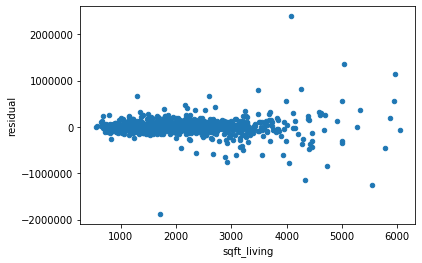

In [70]:
model = Lasso(max_iter=20_000, tol=0.00001, normalize=True, alpha=10)
model.fit(df_train[feature_names], df_train[target_names])
df_test['prediction'] = model.predict(df_test[feature_names])
df_test['residual'] = df_test['prediction'] - df_test[target_names[0]]
df_train['prediction'] = model.predict(df_train[feature_names])
df_train['residual'] = df_train['prediction'] - df_train[target_names[0]]
df_test.plot(kind='scatter', x='sqft_living', y='residual')
print(f"df_test['residual'].std(): {int(df_test['residual'].std())}")
print(f"df_train['residual'].std(): {int(df_train['residual'].std())}")

df_test['residual'].std(): 193072
df_train['residual'].std(): 174445


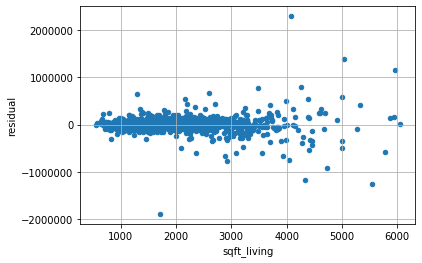

In [71]:
model = Ridge(max_iter=20_000, tol=0.00001, normalize=True, alpha=.2)
model.fit(df_train[feature_names], df_train[target_names])
df_test['prediction'] = model.predict(df_test[feature_names])
df_test['residual'] = df_test['prediction'] - df_test[target_names[0]]
df_train['prediction'] = model.predict(df_train[feature_names])
df_train['residual'] = df_train['prediction'] - df_train[target_names[0]]
df_test.plot(kind='scatter', x='sqft_living', y='residual')
plt.grid('on')
print(f"df_test['residual'].std(): {int(df_test['residual'].std())}")
print(f"df_train['residual'].std(): {int(df_train['residual'].std())}")

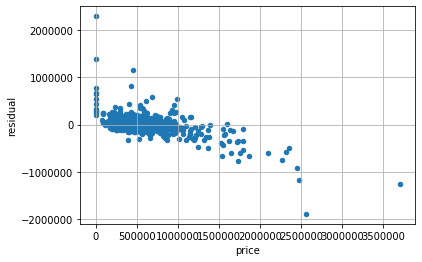

In [72]:
df_test.plot(kind='scatter', x='price', y='residual')
plt.grid('on')